In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
RESULT_DIR = "results"
MODEL_DIR = "models"
os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
class ImageRestorationModel(nn.Module):
    def __init__(self):
        super(ImageRestorationModel, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def apply_damage(self, image):
        img_array = np.array(image)

        # Thêm nhiễu
        noise = np.random.normal(0, 25, img_array.shape)
        img_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)

        # Thêm vết xước
        num_scratches = random.randint(2, 5)
        for _ in range(num_scratches):
            x1, y1 = random.randint(0, img_array.shape[0]-1), random.randint(0, img_array.shape[1]-1)
            x2, y2 = random.randint(0, img_array.shape[0]-1), random.randint(0, img_array.shape[1]-1)
            color = random.randint(200, 255)
            cv2.line(img_array, (y1, x1), (y2, x2), (color, color, color), 2)

        # Làm mờ một phần ảnh
        if random.random() > 0.5:
            x = random.randint(0, img_array.shape[0]-50)
            y = random.randint(0, img_array.shape[1]-50)
            img_array[x:x+50, y:y+50] = cv2.blur(img_array[x:x+50, y:y+50], (5,5))

        return Image.fromarray(img_array)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        original_image = Image.open(image_path).convert('RGB')
        damaged_image = self.apply_damage(original_image)

        if self.transform:
            original_image = self.transform(original_image)
            damaged_image = self.transform(damaged_image)

        return damaged_image, original_image

In [5]:
class ImageRestorer:
    def __init__(self, device=None):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.model = ImageRestorationModel().to(self.device)

    def train_model(self, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

        best_loss = float('inf')
        history = {'train_loss': [], 'val_loss': []}

        for epoch in range(num_epochs):
            # Training
            self.model.train()
            train_loss = 0
            train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

            for damaged, original in train_pbar:
                damaged = damaged.to(self.device)
                original = original.to(self.device)

                outputs = self.model(damaged)
                loss = criterion(outputs, original)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_pbar.set_postfix({'loss': loss.item()})

            avg_train_loss = train_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)

            # Validation
            self.model.eval()
            val_loss = 0
            val_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

            with torch.no_grad():
                for damaged, original in val_pbar:
                    damaged = damaged.to(self.device)
                    original = original.to(self.device)

                    outputs = self.model(damaged)
                    loss = criterion(outputs, original)

                    val_loss += loss.item()
                    val_pbar.set_postfix({'loss': loss.item()})

            avg_val_loss = val_loss / len(test_loader)
            history['val_loss'].append(avg_val_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}')

            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(self.model.state_dict(), 'best_model.pth')

        return history

    def restore_image(self, image_path, output_path=None):
        self.model.eval()
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

        image = Image.open(image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            output_tensor = self.model(input_tensor)

        output_image = transforms.ToPILImage()(output_tensor.squeeze(0).cpu())

        if output_path:
            output_image.save(output_path)

        return output_image

    def load_model(self, model_path):
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()

In [6]:
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(RESULT_DIR, 'training_history.png'))
    plt.close()

In [7]:
DATA_DIR = "/kaggle/input/flickrfaceshq-dataset-ffhq" 
BATCH_SIZE = 8
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001

# Chuẩn bị transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Tạo dataset và chia train/test
full_dataset = ImageDataset(DATA_DIR, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Tạo data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Khởi tạo và huấn luyện model
restorer = ImageRestorer()
history = restorer.train_model(
    train_loader,
    test_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE
)

# Vẽ đồ thị training history
plot_training_history(history)

# Test model với một vài ảnh
test_images = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]
for img_name in test_images:
    input_path = os.path.join(DATA_DIR, img_name)
    output_path = f'restored_{img_name}'
    restorer.restore_image(input_path, output_path)
    print(f'Restored image saved to: {output_path}')

Using device: cuda


Epoch 1/10 [Val]: 100%|██████████| 1301/1301 [05:44<00:00,  3.77it/s, loss=0.00071] 


Epoch [1/10]
Training Loss: 0.0029
Validation Loss: 0.0009


Epoch 2/10 [Val]: 100%|██████████| 1301/1301 [04:49<00:00,  4.49it/s, loss=0.00046] 


Epoch [2/10]
Training Loss: 0.0009
Validation Loss: 0.0008


Epoch 3/10 [Val]: 100%|██████████| 1301/1301 [04:43<00:00,  4.59it/s, loss=0.0005]  


Epoch [3/10]
Training Loss: 0.0007
Validation Loss: 0.0007


Epoch 4/10 [Val]: 100%|██████████| 1301/1301 [04:44<00:00,  4.57it/s, loss=0.000411]


Epoch [4/10]
Training Loss: 0.0007
Validation Loss: 0.0006


Epoch 5/10 [Val]: 100%|██████████| 1301/1301 [04:49<00:00,  4.49it/s, loss=0.000437]


Epoch [5/10]
Training Loss: 0.0006
Validation Loss: 0.0006


Epoch 6/10 [Val]: 100%|██████████| 1301/1301 [04:47<00:00,  4.53it/s, loss=0.00045] 


Epoch [6/10]
Training Loss: 0.0006
Validation Loss: 0.0005


Epoch 7/10 [Val]: 100%|██████████| 1301/1301 [04:51<00:00,  4.46it/s, loss=0.000422]


Epoch [7/10]
Training Loss: 0.0006
Validation Loss: 0.0005


Epoch 8/10 [Val]: 100%|██████████| 1301/1301 [04:56<00:00,  4.38it/s, loss=0.000358]


Epoch [8/10]
Training Loss: 0.0005
Validation Loss: 0.0005


Epoch 9/10 [Val]: 100%|██████████| 1301/1301 [04:48<00:00,  4.50it/s, loss=0.00036] 


Epoch [9/10]
Training Loss: 0.0005
Validation Loss: 0.0005


Epoch 10/10 [Val]: 100%|██████████| 1301/1301 [04:43<00:00,  4.58it/s, loss=0.000393]


Epoch [10/10]
Training Loss: 0.0005
Validation Loss: 0.0005
Restored image saved to: restored_27147.png
Restored image saved to: restored_52235.png
Restored image saved to: restored_32352.png
Restored image saved to: restored_41695.png
Restored image saved to: restored_21130.png


In [9]:
def display_images(image_path, model_path, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = ImageRestorationModel().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    original_image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Tạo đối tượng dataset để tạo ảnh hỏng
    dataset = ImageDataset(DATA_DIR, transform=None)
    damaged_image = dataset.apply_damage(original_image)

    damaged_tensor = transform(damaged_image).unsqueeze(0).to(device)

    with torch.no_grad():
        restored_tensor = model(damaged_tensor)

    to_pil = transforms.ToPILImage()
    restored_image = to_pil(restored_tensor.squeeze(0).cpu())

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Hiển thị ảnh gốc
    axes[0].imshow(original_image)
    axes[0].set_title('Ảnh gốc')
    axes[0].axis('off')

    # Hiển thị ảnh bị hỏng
    axes[1].imshow(damaged_image)
    axes[1].set_title('Ảnh bị hỏng')
    axes[1].axis('off')

    # Hiển thị ảnh đã phục hồi
    axes[2].imshow(restored_image)
    axes[2].set_title('Ảnh đã phục hồi')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return original_image, damaged_image, restored_image


Processing image: 00004.png


/tmp/ipykernel_30/3385447086.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


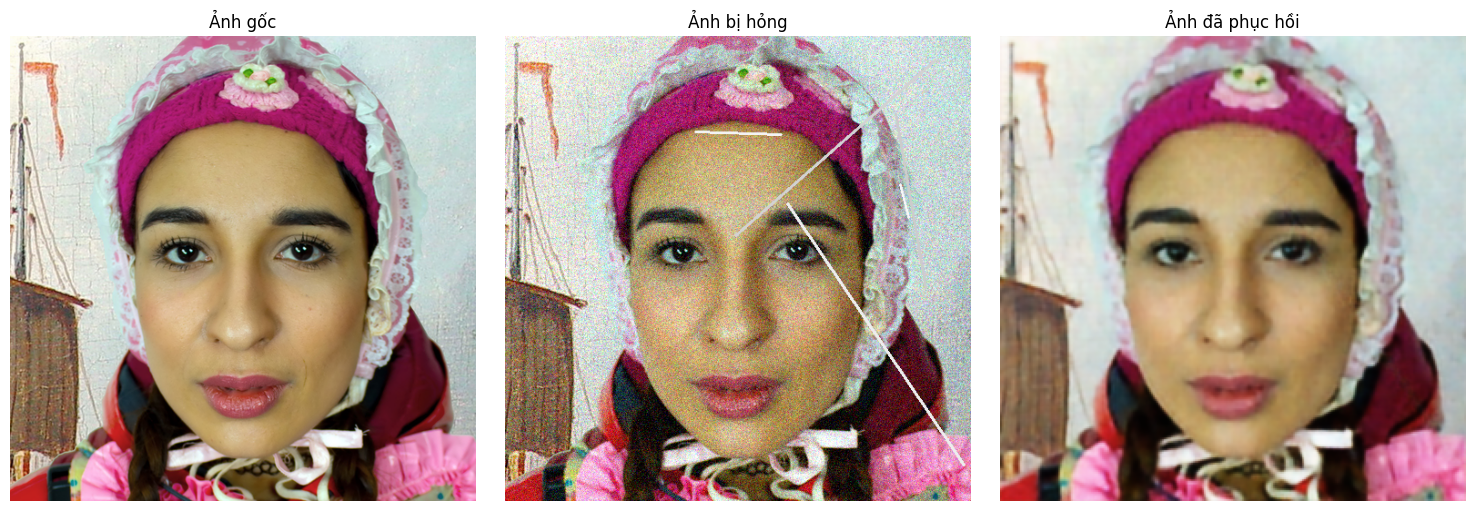


Processing image: 00009.png


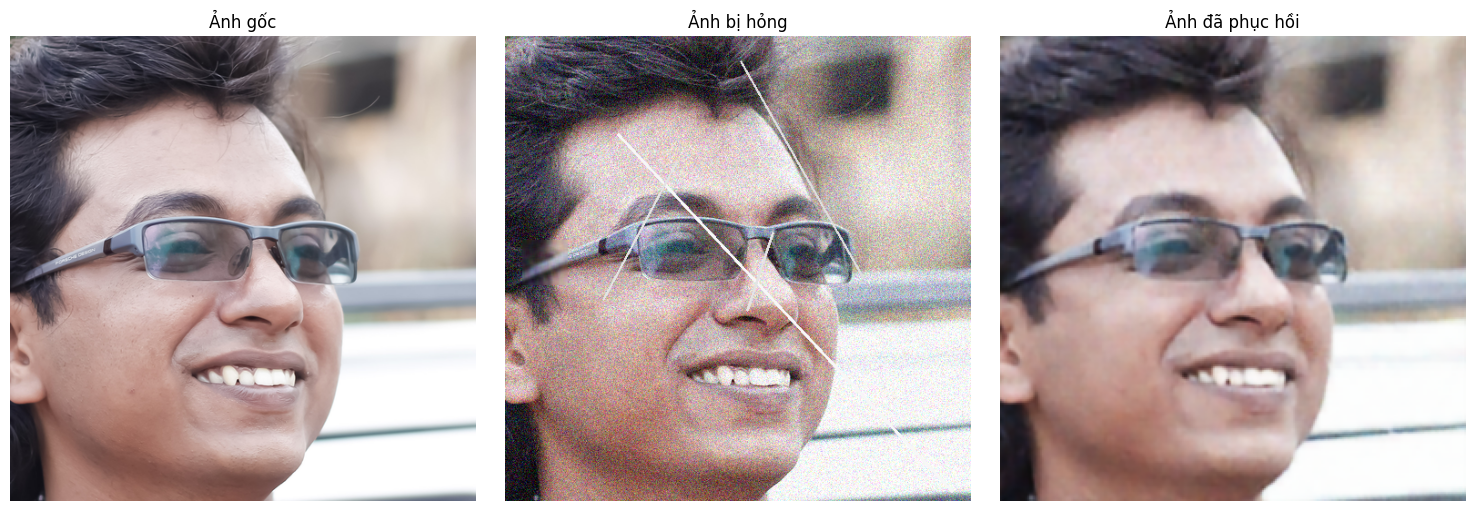


Processing image: 00006.png


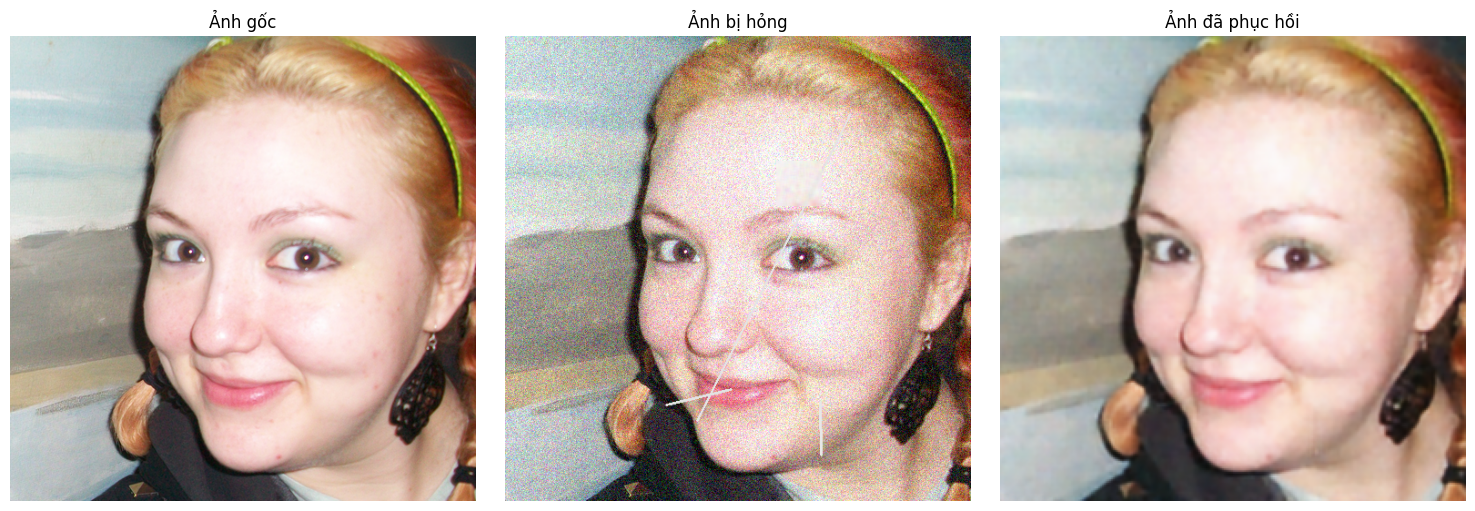

In [10]:
DATA_DIR = "/kaggle/input/test-image"
MODEL_PATH = "/kaggle/working/best_model.pth"

test_images = [f for f in os.listdir(DATA_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]
for img_name in test_images:
    print(f"\nProcessing image: {img_name}")
    image_path = os.path.join(DATA_DIR, img_name)
    original, damaged, restored = display_images(image_path, MODEL_PATH)